In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.12.0
2.12.0


In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import os
from os import listdir
import cv2
import matplotlib.pyplot as plt
import imutils
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import EfficientNetB0
from keras import layers

#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve
import seaborn as sns

In [ ]:
!pip install imutils

In [ ]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/Project Implementation/RIM ONE DL_Data cleaning/Augmented_Train_RIM-ONE_DL')

['normal', 'glaucoma']

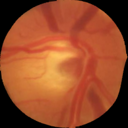

In [ ]:
#showing image of normal
im = Image.open('/content/drive/MyDrive/Colab Notebooks/Project Implementation/RIM ONE DL_Data cleaning/Augmented_Train_RIM-ONE_DL/normal/result_r1_Im001_0_5569.png').resize((128, 128))
im

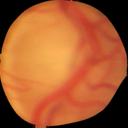

In [ ]:
#showing image of glaucoma
im = Image.open('/content/drive/MyDrive/Colab Notebooks/Project Implementation/RIM ONE DL_Data cleaning/Augmented_Train_RIM-ONE_DL/glaucoma/result_r1_Im113_0_1902.png').resize((128, 128))
im

In [ ]:
#setting the directory of our data
glaucoma = os.listdir('/content/drive/MyDrive/Colab Notebooks/Project Implementation/RIM ONE DL_Data cleaning/Augmented_Train_RIM-ONE_DL/glaucoma')
normal = os.listdir('/content/drive/MyDrive/Colab Notebooks/Project Implementation/RIM ONE DL_Data cleaning/Augmented_Train_RIM-ONE_DL/normal')

#concate two data
data = np.concatenate([glaucoma,normal])
assert (len(data) == len(glaucoma)+len(normal))

#mapping our classes to 1 and 0. 1 == glaucoma and 0 == normal
target_x = np.full(len(glaucoma),1)
target_y = np.full(len(normal),0)

#label of our data
data_target = np.concatenate([target_x,target_y])

assert (len(data_target) == len(target_x)+len(target_y))
assert (len(data_target) == len(data))

print(len(target_x), len(target_y))

960 960


In [ ]:
#Setting the height and width of the image for our model
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SIZE = [IMG_HEIGHT, IMG_WIDTH]

X_data = []

# Reading images from the glaucoma directory, resizing, preprocessing, and appending to the list
for file in glaucoma:
    img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project Implementation/RIM ONE DL_Data cleaning/Augmented_Train_RIM-ONE_DL/glaucoma/' + file)
    img2 = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    preprocessed_img = img2 # I change
    X_data.append(preprocessed_img)

# Reading images from the normal directory, resizing, preprocessing, and appending to the list
for file in normal:
    img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project Implementation/RIM ONE DL_Data cleaning/Augmented_Train_RIM-ONE_DL/normal/' + file)
    img2 = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    preprocessed_img = img2 # I change
    X_data.append(preprocessed_img)

X_data = np.squeeze(X_data)
assert (len(X_data) == len(data) == len(data_target))


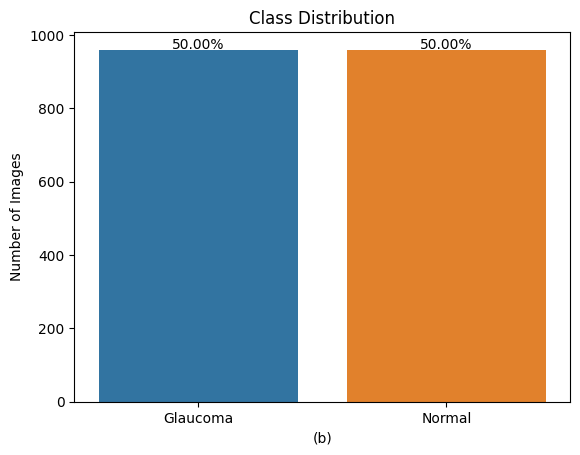

In [ ]:
import seaborn as sns

labels = []
for x in data_target:
  if x == 0:
    labels.append('Normal')
  else:
    labels.append('Glaucoma')

total = len(labels)

#sns.set(style="darkgrid")
ax = sns.countplot(x=labels)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height*100/total),
            ha="center")

plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.xlabel('(b)')
plt.show()

In [ ]:
# normalize data
X = X_data.astype('float32')
X /= 255

In [ ]:
X_data.shape

(1920, 224, 224, 3)

In [ ]:
# split the data into 75:15:15 ratio
X_train, X_test, y_train, y_test = train_test_split(X, data_target, random_state=50, test_size=0.001, stratify = data_target) #change from 0.15 to 0.001

print(len(y_train))
print(len(y_test))

1918
2


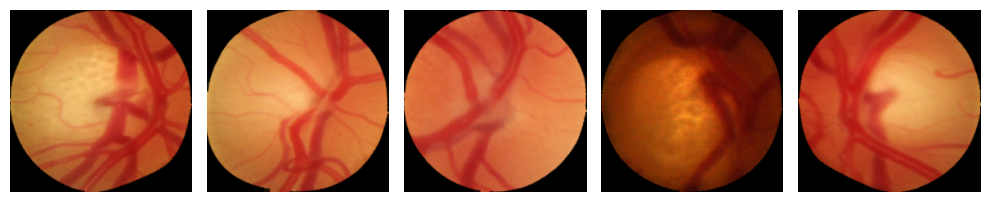

In [ ]:
#I add
#sample of training data
import matplotlib.pyplot as plt
num_samples = 5
fig, axs = plt.subplots(1, num_samples, figsize=(10, 4))

for i in range(num_samples):
    axs[i].imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))  # Assuming grayscale images
    axs[i].set_title(''.format(i))
    axs[i].axis('off')

plt.tight_layout()
plt.show()


# **EfficientNetB0**

In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from efficientnet.tfkeras import EfficientNetB0

def GetEfficientNetB0Model(INPUT_SHAPE=(224, 224, 3), bTrainConvolutionBase=False):
    conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

    if not bTrainConvolutionBase:
        conv_base.trainable = False

    model = Sequential(name='Glaucoma_detection_With_EfficientNet_B0')
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())
    return model


In [ ]:
model = GetEfficientNetB0Model(bTrainConvolutionBase=True)

Model: "Glaucoma_detection_With_EfficientNet_B0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________
None


In [ ]:

# Define the checkpoint filepath
checkpoint_filepath = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/checkpoint_RIM-ONE DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_25_batch_8_lr=0.0001_version2_weights.best.hdf5"

# Create a ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Create an EarlyStopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
#EfficientNetB0     // lr=0.0001  //good
#patience=5
#batch_size=8, #epochs=15, # Train the model
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=15,
    validation_split=0.18,
    callbacks=[checkpoint,
               early_stopping
               ]
)


Epoch 1/15
197/197 [==============================] - 56s 64ms/step - loss: 0.3163 - accuracy: 0.8556 - val_loss: 0.7554 - val_accuracy: 0.5202
Epoch 2/15
197/197 [==============================] - 10s 50ms/step - loss: 0.1169 - accuracy: 0.9612 - val_loss: 0.5766 - val_accuracy: 0.6561
Epoch 3/15
197/197 [==============================] - 10s 49ms/step - loss: 0.0687 - accuracy: 0.9784 - val_loss: 0.0480 - val_accuracy: 0.9942
Epoch 4/15
197/197 [==============================] - 10s 52ms/step - loss: 0.0455 - accuracy: 0.9892 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 5/15
197/197 [==============================] - 9s 48ms/step - loss: 0.0281 - accuracy: 0.9917 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 6/15
197/197 [==============================] - 9s 47ms/step - loss: 0.0243 - accuracy: 0.9943 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 7/15
197/197 [==============================] - 9s 47ms/step - loss: 0.0207 - accuracy: 0.9955 - val_loss: 0.0046 - val_accuracy: 1.

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/Saved_model_RIM-ONE_DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_model.h5')

In [ ]:
import pickle

# Save the history
with open('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/saved_history_RIM-ONE-DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_history.pickle', 'wb') as file:
    pickle.dump(history, file)

# **Model Evaluation**

In [ ]:
history = model.history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']



# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/graphes_aug_RIM-ONE DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_loss_graph.png')#add
plt.show()

# Accuracy#
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/graphes_aug_RIM-ONE DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_accuracy_graph.png')
plt.show()

# **To test the trained model on a test set**


In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout

#I add this later
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

# Define the path to the new test dataset folder
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/Project Implementation/RIM ONE DL_Data cleaning/RIM-ONE_DL_Split/Test(RIM-ONE_DL epch 15 batch 8 version2)'
#test_data_dir = '/content/drive/MyDrive/Colab Notebooks/Project Implementation/HRF_Data cleaning/HRF_after_segmentation_and_ROI'

# Load the trained model



#version2 lr=0.0001
#batch 8

##The best
model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/Saved_model_RIM-ONE_DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_model.h5')


# Preprocess the new test dataset
IMG_HEIGHT = 224
IMG_WIDTH = 224

X_test_new = []
y_test_new = []

for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            image = image / 255.0  # Normalize pixel values to [0, 1]
            X_test_new.append(image)
            if class_name == 'glaucoma':
                y_test_new.append(1)
            else:
                y_test_new.append(0)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)


In [ ]:
#
#I add this
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
from keras.models import load_model
# load model

##The best
model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/Saved_model_RIM-ONE_DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_model.h5')




_, acc = model.evaluate(X_test_new, y_test_new)#I change here
print("Accuracy = ", (acc * 100.0), "%")

3/3 [==============================] - 3s 174ms/step - loss: 0.0664 - accuracy: 0.9773
Accuracy =  97.72727489471436 %


In [ ]:
# Make predictions on the new test data
y_pred_new = model.predict(X_test_new)
y_pred_new = [1 if x >=       0.738232 else 0 for x in y_pred_new]# I change from 0.5 to 0.208687, 0.767894


3/3 [==============================] - 0s 22ms/step


In [ ]:
#for epoch 15  batch 8 // Test(RIM-ONE_DL epoch 15 batch 8 version2) //threshold  0.738232 *  //patcince 5 //lr=0.0001  ///// best
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Calculate performance metrics
accuracy = accuracy_score(y_test_new, y_pred_new)
precision = precision_score(y_test_new, y_pred_new)
recall = recall_score(y_test_new, y_pred_new)
f1_score = f1_score(y_test_new, y_pred_new)
auc = roc_auc_score(y_test_new, y_pred_new)
confusion_matrix = confusion_matrix(y_test_new, y_pred_new)

# Calculate specificity
specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
print("AUC:", auc)
print("Specificity:", specificity)
print("Confusion Matrix:\n", confusion_matrix)

# Generate classification report
target_names = ['normal', 'glaucoma']
classification_rep = classification_report(y_test_new, y_pred_new, target_names=target_names)

# Print the classification report
print(classification_rep)

Accuracy: 0.9886363636363636
Precision: 1.0
Recall: 0.9772727272727273
F1-score: 0.9885057471264368
AUC: 0.9886363636363636
Specificity: 1.0
Confusion Matrix:
 [[44  0]
 [ 1 43]]
              precision    recall  f1-score   support

      normal       0.98      1.00      0.99        44
    glaucoma       1.00      0.98      0.99        44

    accuracy                           0.99        88
   macro avg       0.99      0.99      0.99        88
weighted avg       0.99      0.99      0.99        88



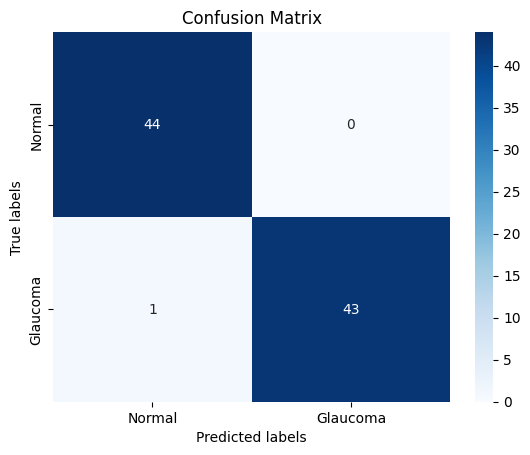

In [ ]:
#for epoch 15  batch 8 // Test(RIM-ONE_DL epch 15 batch 8 version2) //threshold  0.738232 *  //patcince 5 //lr=0.0001  ///// best
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test_new, y_pred_new)

# Plot the confusion matrix
labels = ["Normal", "Glaucoma"]
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Save the figure
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/good_graph_Aug_RIM-ONE_DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_confusion_matrix.png")

# Show the figure
plt.show()


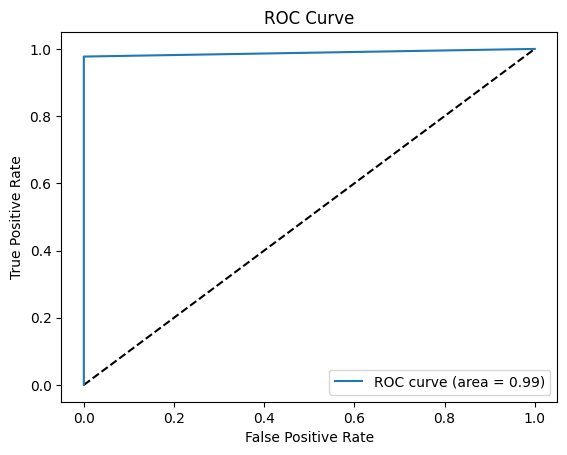

In [ ]:
#for epoch 15  batch 8 // Test(RIM-ONE_DL epch 15 batch 8 version2) //threshold  0.738232 *  //patcince 5 //lr=0.0001  ///// best
#ROC Curve


fpr, tpr, thresholds = roc_curve(y_test_new, y_pred_new)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr, tpr, label='EfficientNetB0')
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/good_graph_Aug_RIM-ONE_DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_ROC Curve_graph.png')
plt.show();

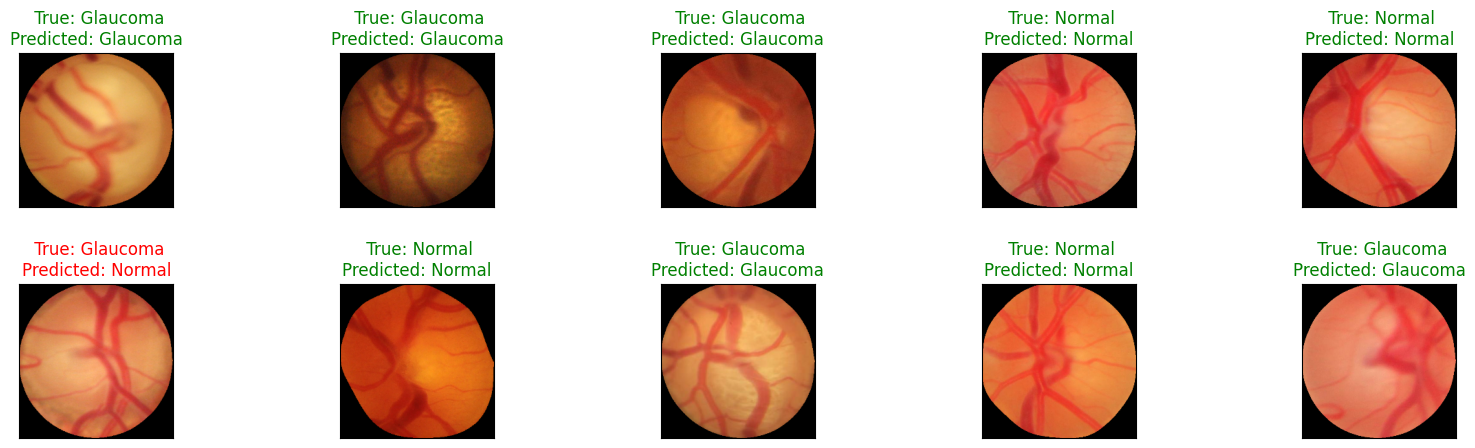

In [ ]:
#for epoch 15  batch 8 // Test(RIM-ONE_DL epch 15 batch 8 version2) //threshold  0.738232 *  //patcince 5 //lr=0.0001  ///// best
import cv2
import matplotlib.pyplot as plt
import numpy as np

labels = ["Normal", "Glaucoma"]

figure = plt.figure(figsize=(20, 8))

for i, index in enumerate(np.random.choice(X_test_new.shape[0], size=10, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Read the image in BGR format
    bgr_image = np.squeeze(X_test_new[index])
    # Convert the image to 8-bit (values between 0 and 255)
    bgr_image_8bit = cv2.normalize(bgr_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Convert the 8-bit BGR image to RGB
    rgb_image = cv2.cvtColor(bgr_image_8bit, cv2.COLOR_BGR2RGB)
    # Display the RGB image
    ax.imshow(rgb_image)
    predict_index = y_pred_new[index]
    true_index = y_test_new[index]
    # Set the title for each image
    true_label = labels[true_index]
    predict_label = labels[predict_index]
    title = " True: {}\nPredicted: {}".format(true_label, predict_label)
    ax.set_title(title, color=("green" if predict_index == true_index else "red"))

# Adjust the spacing between the subplots
figure.subplots_adjust(hspace=0.5)

# Save the figure
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/good_graph_Aug_RIM-ONE_DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_test_sample_images.png')

1/1 [==============================] - 1s 1s/step


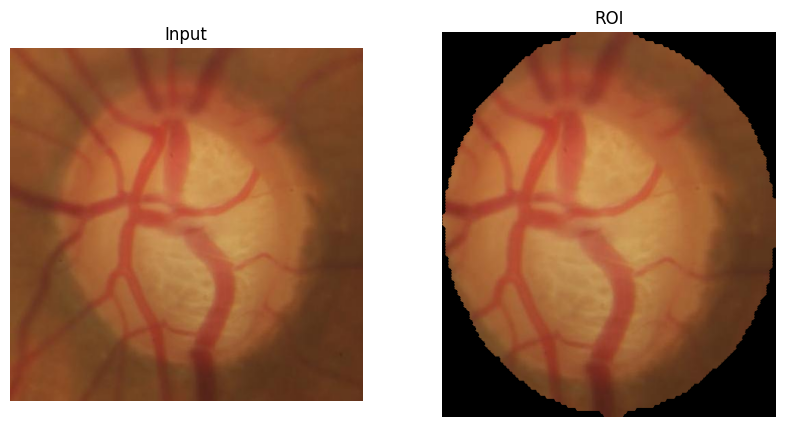

The prediction for the image is: Glaucoma


In [ ]:
#To test model on test set
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt


#I add
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

# Load the segmentation model
segmentation_model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/Saved_model/Segmentation_UNET_Resnet34_ORIGA&RIMONEDL_with_Aug_V2_2040_without_denoising_Epoch_50_batch_16.hdf5', compile=False)

#Load the classification model
classification_model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/Saved_model_RIM-ONE_DL/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_RIM-ONE_DL_epoch_15_batch_8_lr=0.0001_version2_model.h5')
#
# Define the preprocessing function for the segmentation model
def preprocess_segmentation_image(image):
    # Apply resize
    new_width = 128
    new_height = 128
    dim = (new_width, new_height)
    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    # Preprocess the image
    preprocessed_image = resized_image / 255.
    return preprocessed_image

# Define the preprocessing function for the classification model
def preprocess_classification_image(image):
    # Resize the image
    img = cv2.resize(image, (224, 224))
    # Normalize the image
    img = img.astype('float32') / 255
    # Reshape the image to match the model's input shape
    img = np.expand_dims(img, axis=0)
    return img

# Load the image
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project Implementation/RIM ONE DL_Data cleaning/RIM ONE DL_before cropped/Images/glaucoma/r2_Im289.png')

# Preprocess the image for segmentation
preprocessed_image = preprocess_segmentation_image(image)

# Make segmentation prediction
segmentation_prediction = segmentation_model.predict(np.expand_dims(preprocessed_image, axis=0))
segmentation_mask = np.argmax(segmentation_prediction, axis=3)[0]

# Resize the mask to match the image size
segmentation_mask_resized = cv2.resize(segmentation_mask.astype(np.uint8), (image.shape[1], image.shape[0]))


# Apply the mask to the original image
segmented_image = cv2.bitwise_and(image, image, mask=segmentation_mask_resized)

# Convert the segmented image to grayscale
gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# Find contours in the grayscale image
contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the bounding rectangle for each contour
bounding_rectangles = [cv2.boundingRect(contour) for contour in contours]

# Get the x, y, w, h of the bounding rectangle with the maximum area
x, y, w, h = max(bounding_rectangles, key=lambda rect: rect[2] * rect[3])

# Crop the black area from the segmented image
cropped_segmented_image = segmented_image[y:y+h, x:x+w]

# Preprocess the cropped segmented image for classification
preprocessed_segmented_image = preprocess_classification_image(cropped_segmented_image)

# Make classification prediction
classification_prediction = classification_model.predict(preprocessed_segmented_image)
label = "Glaucoma" if classification_prediction[0][0] >= 0.738232 else "Normal" #rather than 0.5

# Display the images and prediction using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Input')
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(cropped_segmented_image, cv2.COLOR_BGR2RGB))
axs[1].set_title('ROI')
axs[1].axis('off')
plt.show()

print(f"The prediction for the image is: {label}")
